### Importar de Bibliotecas:

In [1]:
from __future__ import print_function, division

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.image import imread
from IPython.display import Image, display
from PIL import Image as Imagem

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable

import numpy as np
import os
import time
import copy
import time
from datetime import timedelta

import tensorflow as tf
from tensorboardX import SummaryWriter

plt.ion()

In [2]:
#### Verificação das Versões

In [3]:
tf.__version__

'1.14.0'

In [4]:
torch.__version__

'1.3.0'

#### Importar funções e classes provenientes dos arquivos inception.py e knifey.py
As funções e classes knifey e inception irão nos auxiliar ao tentarmos dividir o dataset em clusters

In [5]:
import inception

In [6]:
import knifey

In [7]:
knifey.data_dir = "data/movedataset/"
data_dir = knifey.data_dir
dataset = knifey.load()

Creating dataset from the files in: data/movedataset/
- Data loaded from cache-file: data/movedataset/knifey-spoony.pkl


In [8]:
class_names = dataset.class_names
class_names

['conformes', 'nao-conformes']

In [9]:
num_classes = len(class_names)

In [10]:
image_paths_train, cls_train, labels_train = dataset.get_training_set()
image_paths_test, cls_test, labels_test = dataset.get_test_set()

In [11]:
print (image_paths_train[0])
print (image_paths_test[0])

C:\Users\bruno\Documents\TCC\Codes\data\movedataset\conformes\20191008_151033.jpg
C:\Users\bruno\Documents\TCC\Codes\data\movedataset\conformes\test/20191008_151039.jpg


In [12]:
#### Carregar o Modelo Inception

In [13]:
model = inception.Inception()

Instructions for updating:
Use tf.gfile.GFile.




In [14]:
#### Inferência sobre o modelo criado

In [15]:
model=torch.load('prediction_ft_model.pth')

In [16]:
model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
def process_image(image_path):
    # Load Image
    img = Imagem.open(image_path)
    
    # Get the dimensions of the image
    width, height = img.size
    
    # Resize by keeping the aspect ratio, but changing the dimension
    # so the shortest size is 255px
    img = img.resize((255, int(255*(height/width))) if width < height else (int(255*(width/height)), 255))
    
    # Get the dimensions of the new image size
    width, height = img.size
    
    # Set the coordinates to do a center crop of 224 x 224
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2
    img = img.crop((left, top, right, bottom))
    
    # Turn image into numpy array
    img = np.array(img)
    
    # Make the color channel dimension first instead of last
    img = img.transpose((2, 0, 1))
    
    # Make all values between 0 and 1
    img = img/255
    
    # Normalize based on the preset mean and standard deviation
    img[0] = (img[0] - 0.485)/0.229
    img[1] = (img[1] - 0.456)/0.224
    img[2] = (img[2] - 0.406)/0.225
    
    # Add a fourth dimension to the beginning to indicate batch size
    img = img[np.newaxis,:]
    
    # Turn into a torch tensor
    image = torch.from_numpy(img)
    image = image.float()
    return image

In [19]:
def predict(image, model):
    # Pass the image through our model
    output = model.forward(image)
    
    # Reverse the log function in our output
    output = torch.exp(output)
    
    # Get the top predicted class, and the output percentage for
    # that class
    probs, classes = output.topk(1, dim=1)
    return probs.item(), classes.item()

In [20]:
# Show Image
def show_image(image):
    # Convert image to numpy
    image = image.numpy()
    
    # Un-normalize the image
    image[0] = image[0] * 0.226 + 0.445
    
    # Print the image
    fig = plt.figure(figsize=(25, 4))
    plt.imshow(np.transpose(image[0], (1, 2, 0)))

In [21]:
image = process_image("20191211_164531.jpg")

In [22]:
top_prob, top_class = predict(image, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


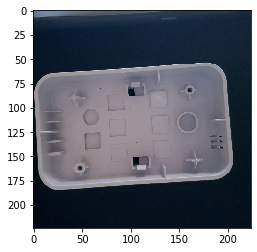

In [23]:
show_image(image)

In [24]:
print('Classe: ',class_names[top_class]  )

Classe:  nao-conformes


In [25]:
data_dir_infer = './data/dataset/val'

In [26]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir_infer, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [27]:
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])

In [28]:
images, labels = get_random_images(5)

In [29]:
os.chdir('./data/dataset/test/conformes')
conformes = os.listdir('.')

In [30]:
pred_conforme=[]
for conf in conformes:
    image = process_image(conf)
    top_prob, top_class = predict(image, model)
    pred_conforme.append(top_class)

In [31]:
cont_conforme_in_conforme=0
cont_n_conforme_in_conforme=0
for i in pred_conforme:
    if i == 0:
        cont_conforme_in_conforme+=1
    else:
        cont_n_conforme_in_conforme+=1
print('conformes em conformes:',cont_conforme_in_conforme)
print('não conformes em conformes:',cont_n_conforme_in_conforme)

conformes em conformes: 23
não conformes em conformes: 7


In [32]:
os.chdir('../nao-conformes')
nao_conformes = os.listdir('.')

In [33]:
pred_n_conforme=[]
for nconf in nao_conformes:
    image = process_image(nconf)
    top_prob, top_class = predict(image, model)
    pred_n_conforme.append(top_class)

In [34]:
cont_nconforme_in_nconforme=0
cont_conforme_in_nconforme=0
for i in pred_n_conforme:
    if i == 1:
        cont_nconforme_in_nconforme+=1
    else:
        cont_conforme_in_nconforme+=1
print('não-conformes em não-conformes:',cont_nconforme_in_nconforme)
print('conformes em não-conformes:',cont_conforme_in_nconforme)

não-conformes em não-conformes: 33
conformes em não-conformes: 0


In [38]:
import pandas as pd
import seaborn as sn

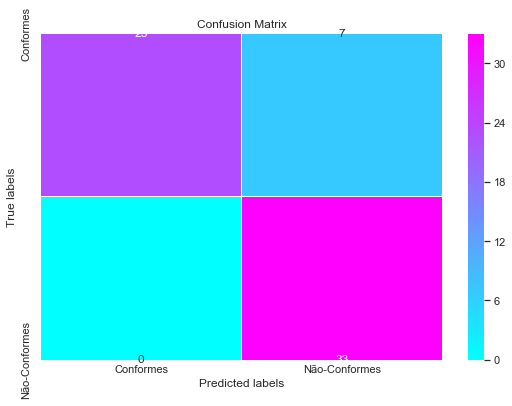

In [44]:

array = [[cont_conforme_in_conforme,cont_n_conforme_in_conforme],
         [cont_conforme_in_nconforme,cont_nconforme_in_nconforme]]        
df_cm = pd.DataFrame(array)
f, ax = plt.subplots(figsize=(9, 6))
sn.set()
sn.heatmap(df_cm, annot=True,linewidths=.5,fmt="d",ax=ax, cmap='cool')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Conformes', 'Não-Conformes'],va="center"); ax.yaxis.set_ticklabels(['Conformes', 'Não-Conformes'],va="center");